In [25]:
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from IPython import display
from sklearn import metrics

In [66]:
raw_training_df = pd.read_csv('train.csv')
raw_testing_df = pd.read_csv('test.csv')

In [27]:
print raw_training_df.head()
print raw_training_df.shape

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.0      1   
2                             Heikkinen, Miss. Laina  female 26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.0      1   
4                           Allen, Mr. William Henry    male 35.0      0   

   Parch            Ticket  Fare Cabin Embarked  
0      0         A/5 21171   7.2   NaN        S  
1      0          PC 17599  71.3   C85        C  
2      0  STON/O2. 3101282   7.9   NaN        S  
3      0            113803  53.1  C123        S  
4      0            373450   8.1   NaN        S  
(891, 12)


Target Column: Survived

Features that can be used:
1. Pclass (Categorical: 1, 2, 3)
2. Age (Continuous, bucketized: 0-10, 11-20, 21-30, etc)
3. Fare (Continuous, bucketized: 0-30, 31-60, 61-90, etc)
4. Sex (Categorical: male, female)

In [52]:
def preprocess_features(titanic_dataframe):
    output_features = titanic_dataframe[[
        "Pclass",
        "Age",
        "Fare",
        "Sex"
    ]].copy()    
    pclass_feature_column = tf.feature_column.bucketized_column(
            source_column = tf.feature_column.numeric_column(key='Pclass'),
            boundaries = [1, 2, 3])
    age_feature_column = tf.feature_column.bucketized_column(
            source_column = tf.feature_column.numeric_column(key='Age'),
            boundaries = [15, 30, 45, 60])
    fare_feature_column = tf.feature_column.bucketized_column(
            source_column = tf.feature_column.numeric_column(key='Fare'),
            boundaries = [60, 120, 180, 300, 400])
    sex_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key="Sex",
            vocabulary_list=["male", "female"])
    
    feature_columns = [
        pclass_feature_column,
        age_feature_column,
        fare_feature_column,
        sex_feature_column
    ]    
    return output_features, feature_columns
    

def preprocess_targets(titanic_dataframe):
    output_targets = pd.DataFrame()
    output_targets['Survived'] = (titanic_dataframe['Survived'] == 1).astype(int)
    return output_targets

# Set the output display to have one digit for decimal places, for display readability only.
pd.options.display.float_format = '{:.1f}'.format

# randomize the data before selecting train / validation splits.
raw_training_df = raw_training_df.reindex(np.random.permutation(raw_training_df.index))

In [67]:
# choose the first 800 (out of 891) examples for training.
training_examples, feature_columns = preprocess_features(raw_training_df.head(800))
training_targets = preprocess_targets(raw_training_df.head(800))

# choose the last 91 (out of 891) examples for validation.
validation_examples, feature_columns = preprocess_features(raw_training_df.tail(91))
validation_targets = preprocess_targets(raw_training_df.tail(91))

testing_examples, feature_columns = preprocess_features(raw_testing_df)

In [54]:
# Sanity check that we've done the right thing.
print "Training examples summary"
display.display(training_examples.describe())
print "Validation examples summary"
display.display(validation_examples.describe())

print "Training targets summary"
display.display(training_targets.describe())
print "Validation targets summary"
display.display(validation_targets.describe())

Training examples summary


,Pclass,Age,Fare
count,800.0,641.0,800.0
mean,2.3,29.9,32.9
std,0.8,14.6,51.4
min,1.0,0.4,0.0
25%,1.8,21.0,7.9
50%,3.0,29.0,14.5
75%,3.0,39.0,31.3
max,3.0,80.0,512.3


Validation examples summary


,Pclass,Age,Fare
count,91.0,73.0,91.0
mean,2.5,28.3,26.0
std,0.8,13.9,29.9
min,1.0,2.0,0.0
25%,2.0,20.0,7.9
50%,3.0,25.0,13.0
75%,3.0,36.0,28.4
max,3.0,62.0,151.6


Training targets summary


,Survived
count,800.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary


,Survived
count,91.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [65]:
LEARNING_RATE = 0.0000001
STEPS = 5000

# Placed outside the main training function for reusability
predict_validation_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=validation_examples, 
    y=validation_targets["Survived"], shuffle=False
)

def train_regressor_model(learning_rate, steps):
    """Trains a linear regressor model"""
    predict_training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=training_examples,
        y=training_targets["Survived"], shuffle=False
    )
    
    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=training_examples,
        y=training_targets["Survived"], shuffle=False
    )
    
    model = tf.contrib.learn.LinearClassifier(
        feature_columns=feature_columns,
        optimizer=tf.train.GradientDescentOptimizer(learning_rate),
        gradient_clip_norm=5.0
    )
    
    # Train the model.
    print "Training model..."
    model.fit(input_fn=training_input_fn, steps=steps)
    print "Model training finished."
    
    training_predictions = list(model.predict_classes(input_fn=predict_training_input_fn, as_iterable=True))
    print training_predictions
    print "\nThe training prediction lie in the range [%.1f, %.1f]" % (
        min(training_predictions), max(training_predictions)
    )
    print model.evaluate(input_fn=predict_training_input_fn)
    return model

linear_classifier = train_regressor_model(LEARNING_RATE, STEPS)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c19e54c50>, '_model_dir': '/var/folders/fc/dksnrdt17g34y_bbrnthgrc00000gn/T/tmpYoVNVO', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_master': ''}
Training model...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/fc/dksnrdt17g34y_bbrnthgrc00000gn/T/tmpYoVNVO/model.ckpt.
INFO:tensorflow:loss = 0.693147, step = 1
INFO:tensorflow:Saving checkpoints for 7 into /var/folders/fc/

INFO:tensorflow:Starting evaluation at 2018-01-01-01:48:45
INFO:tensorflow:Restoring parameters from /var/folders/fc/dksnrdt17g34y_bbrnthgrc00000gn/T/tmpYoVNVO/model.ckpt-7
INFO:tensorflow:Finished evaluation at 2018-01-01-01:48:46
INFO:tensorflow:Saving dict for global step 7: accuracy = 0.648352, accuracy/baseline_label_mean = 0.351648, accuracy/threshold_0.500000_mean = 0.813187, auc = 0.5, auc_precision_recall = 0.675824, global_step = 7, labels/actual_label_mean = 0.351648, labels/prediction_mean = 0.5, loss = 0.693147, precision/positive_threshold_0.500000_mean = 0.0, recall/positive_threshold_0.500000_mean = 0.0
AUC on the validation set: 0.50
Accuracy on the validation set: 0.65
INFO:tensorflow:Restoring parameters from /var/folders/fc/dksnrdt17g34y_bbrnthgrc00000gn/T/tmpYoVNVO/model.ckpt-7


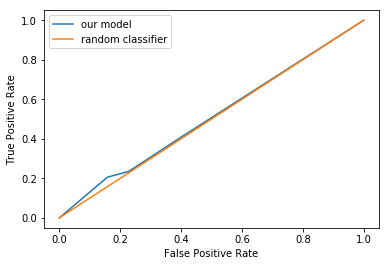

In [71]:
# Evaluate a logistic regression model.
evaluation_metrics = linear_classifier.evaluate(
    input_fn=predict_validation_input_fn)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']

# Obtain the prediction probabilities
validation_probs = np.array(list(linear_classifier.predict_proba(
    input_fn=predict_validation_input_fn, as_iterable=True)))

# Calculate and plot ROC curve
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(validation_targets, validation_probs[:, 1])
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=2)
plt.show()

In [92]:
# Predict survival on test data set
predict_testing_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=testing_examples, shuffle=False
)

testing_predictions = pd.Series(
    list(linear_classifier.predict_classes(input_fn=predict_testing_input_fn, as_iterable=True)))

output_df = pd.DataFrame()
output_df['PassengerId'] = raw_testing_df['PassengerId']
output_df['Survived'] = testing_predictions

output_df.to_csv('./out.csv', index=False)

INFO:tensorflow:Restoring parameters from /var/folders/fc/dksnrdt17g34y_bbrnthgrc00000gn/T/tmpYoVNVO/model.ckpt-7
<class 'pandas.core.series.Series'>
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
(418, 2)
